# Stereonet analysis of fault planes

## Contour mapping and agglomerative clustering.

A set of labeled fault plane orientation data is analysed using the publicly available library
mplstereonet (https://github.com/joferkington/mplstereonet) and scikit-learn (http://scikit-learn.org/)
The goal is to find groups of fault planes sharing similar traits by applying unsupervised learning methods such as agglomerative clustering.
It is necessary to use a clustering algorithm that honors non-euclidean geometry of points on a sphere and their respective distance metric to each other.

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import mplstereonet

import numpy as np

from sklearn.cluster import AgglomerativeClustering, DBSCAN
from sklearn.metrics import pairwise_distances
from sklearn import metrics

import pandas as pd

from collections import namedtuple

## Input fault plane data reading and parsing 

Data is input in a column based layout. First column being dip-direction of fault planes. Second column is the dip angle of the fault plane. Third column is a unique plane identifier.
We open and read in the data contained in file_name by standard library methods.

In [2]:
file_name = 'data\\tec_st.txt'

#read using pandas read_csv method
fault_data = pd.read_csv(file_name)
print fault_data.head()

   Dip Direction  Dip       Name
0             60   80  PAST4 MP1
1            178   75      PAST5
2              5   85      PAST6
3              4   65  LIST1 MP1
4             96   53      LIST1


The mplstereonet library expects data to be input for plotting as strike and dip angles.
Fortunatly the library provides us with helper functions to convert dip-direction to strike.
We do so and read in strikes, dips and unique fault identifiers.

In [3]:
#Use a namedtuple for simple named storage, use verbose=True for implemented methods
Point = namedtuple('Point', ['lon', 'lat'], verbose=False)

#Use mplstereonet method to convert dip direction to strike
fault_data['Strike'] = fault_data['Dip Direction'].apply(mplstereonet.utilities.dip_direction2strike)
fault_data['Pole'] = fault_data.apply(lambda row: mplstereonet.pole(row['Strike'], row['Dip']), axis=1)
fault_data['Pole'] = fault_data['Pole'].apply(lambda x: Point(float(x[0]), float(x[1])))
print fault_data.head()

   Dip Direction  Dip       Name  Strike                                Pole
0             60   80  PAST4 MP1     330   (-1.36993697095, -0.514849513905)
1            178   75      PAST5      88      (-0.12951759139, 1.3067330364)
2              5   85      PAST6     275   (-0.783491887771, -1.44746133687)
3              4   65  LIST1 MP1     274    (-0.14849211528, -1.12926901725)
4             96   53      LIST1       6  (-0.922382331762, 0.0835774091863)


## Contour plot of fault plane poles and fault identifier labels.

We plot the poles of the fault plane data set using the mplstereonet library.
Additionaly we contour using the exponential kamb method at a sigma=2 level.
Contours are at sigma = 1, 2, 4, 6, 8 levels.
Annotation of the data points allows us to identify fault planes in the plot.

C:\Users\lmosser\Anaconda\lib\site-packages\matplotlib\collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
C:\Users\lmosser\Anaconda\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


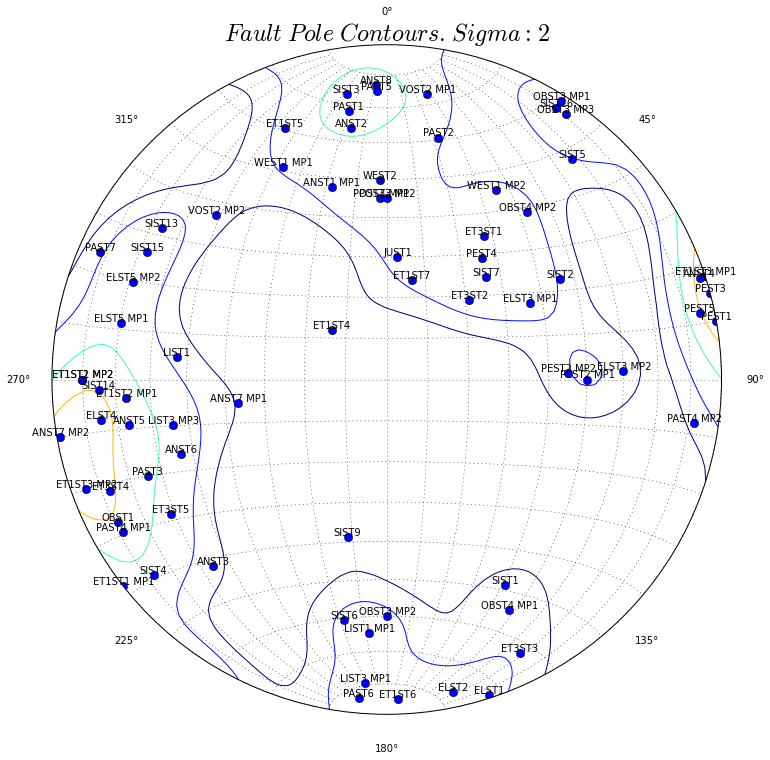

In [4]:
fig = plt.figure(figsize=(12,12))

#Contour sigma level 2 and range of contours
sigma = 2
contour = [1,2,4,6,8]

plot_title = r'$Fault \ Pole \ Contours. \ Sigma: \ '+str(sigma)+'$'

#Formating options for titles and markers
title_font_size = 24
label_font_size= 10
fault_pole_marker = 'o'
fault_pole_marker_size = 8
fault_pole_marker_color = 'blue'

#use equal area stereonet as projection method
ax = fig.add_subplot(111, projection='equal_area_stereonet')

#Iterate over all rows in the pandas DataFrame to add labels; no labels just provide columns as arguments
for index, row in fault_data.iterrows():
    ax.pole(row['Strike'], row['Dip'], fault_pole_marker, markersize=fault_pole_marker_size, color=fault_pole_marker_color)
    ax.annotate(row['Name'], ha='center', va='bottom', xy=(row['Pole'].lon, row['Pole'].lat), fontsize=label_font_size)

#Contour plot of data points
ax.density_contour(fault_data['Strike'], fault_data['Dip'], measurement='poles', method='exponential_kamb', sigma=sigma, levels=contour)    

#Add grid, show title and show plot
ax.grid()
ax.set_title(plot_title, fontsize=title_font_size)
plt.show()

## Great circle distance computation for distance matrix computation.

We define a computationally precise formula for the great circle distance of two points given as longitude and latitude coordinates. u and v are arrays designating points u and v. u[0] is the points latitude and u[1] its longitude. (http://en.wikipedia.org/wiki/Great-circle_distance)

In [5]:
def great_circle(u, v, r=1.):
    dsig = np.arctan(np.sqrt(np.power(np.cos(v[0])*np.sin(u[1]-v[1]),2)
                            +np.power(np.cos(u[0])*np.sin(v[0])-np.sin(u[0])*np.cos(v[0])*np.cos(u[1]-v[1]),2))
                            /(np.sin(u[0])*np.sin(v[0])+np.cos(u[0])*np.cos(v[0])*np.cos(u[1]-v[1])))
    return np.abs(r*dsig)

We now convert our strikes and dip angles of our fault plane poles to latitude and longitude.
We save these points in an array called points for later usage.

In [6]:
Point = namedtuple('Point', ['lon', 'lat'], verbose=False)

fault_data['Pole'] = fault_data.apply(lambda row: mplstereonet.pole(row['Strike'], row['Dip']), axis=1)
fault_data['Pole'] = fault_data['Pole'].apply(lambda x: Point(float(x[0]), float(x[1])))
print fault_data.head()

   Dip Direction  Dip       Name  Strike                                Pole
0             60   80  PAST4 MP1     330   (-1.36993697095, -0.514849513905)
1            178   75      PAST5      88      (-0.12951759139, 1.3067330364)
2              5   85      PAST6     275   (-0.783491887771, -1.44746133687)
3              4   65  LIST1 MP1     274    (-0.14849211528, -1.12926901725)
4             96   53      LIST1       6  (-0.922382331762, 0.0835774091863)


## Distance Matrix for great-circle distance fault poles.

Agglomerative clustering in scikit-learn can handle precomputed distance matrices.
As no metric is included in scikit-learn or scipy.distance we precompute the distance matrix manually before the actual clustering algorithm is applied. See flag AgglomerativeClustering(affinity="precomputed")

In [7]:
matrix = []
for point_a in fault_data['Pole'].values:
    row = []
    for point_b in fault_data['Pole'].values:
        d = great_circle(point_a, point_b)
        row.append(d)
    matrix.append(row)

#Convert array of arrays to a numpy matrix for compatibility.
dist = np.matrix(matrix)
print dist     

[[ 0.          1.49325668  0.68285709 ...,  0.92046792  0.33593036
   0.30190748]
 [ 1.49325668  0.          0.97724698 ...,  1.02808342  1.46017952
   1.56975333]
 [ 0.68285709  0.97724698  0.         ...,  1.46438383  0.8325248
   0.61293846]
 ..., 
 [ 0.92046792  1.02808342  1.46438383 ...,  0.          0.64460726
   1.20390702]
 [ 0.33593036  1.46017952  0.8325248  ...,  0.64460726  0.          0.63634079]
 [ 0.30190748  1.56975333  0.61293846 ...,  1.20390702  0.63634079  0.        ]]


## Agglomerative Clustering of Fault Poles

We now apply the AgglomerativeClustering algorithm to create n-clusters for the given dataset.
We then plot the dataset together with the pole points, cluster coloured and their respective fault identifier label.

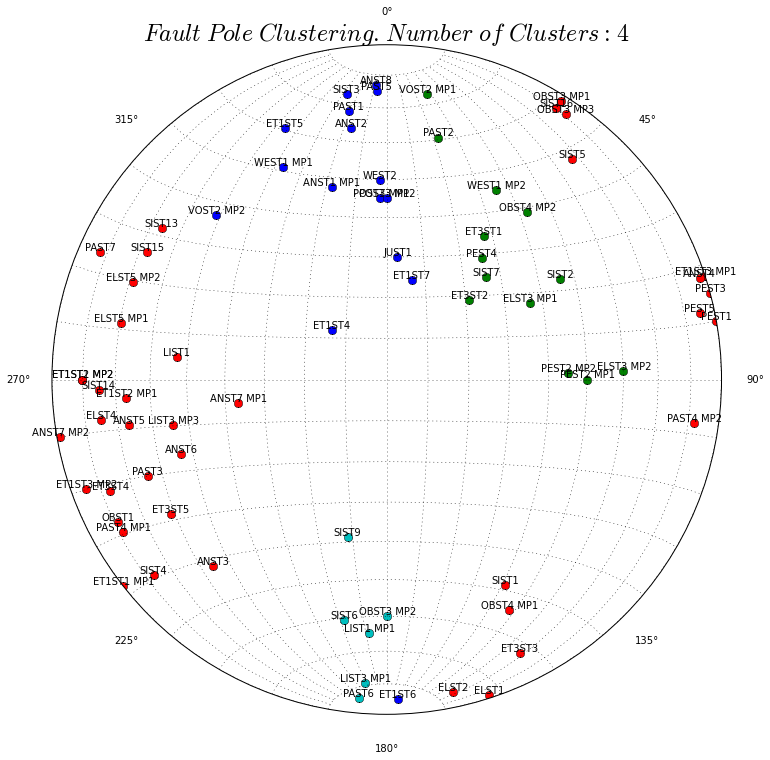

In [9]:
fig = plt.figure(figsize=(12,12))

fig_out_name = 'fault_pole_clusters.png'
n_clusters = 4

plot_title = r'$Fault \ Pole \ Clustering. \ Number \ of \ Clusters: \ '+str(n_clusters)+'$'
title_font_size = 24
label_font_size = 10
fault_pole_marker = 'o'
fault_pole_marker_size = 8

ax = fig.add_subplot(111, projection='equal_area_stereonet')
model = AgglomerativeClustering(n_clusters=n_clusters, linkage="complete", affinity="precomputed")
model.fit_predict(dist)

fault_data['Cluster'] = model.labels_
color_str = "rgbcymk"
fault_data['Color'] = fault_data['Cluster'].apply(lambda x: color_str[x])

for index, row in fault_data.iterrows():
    ax.pole(row['Strike'], row['Dip'], fault_pole_marker, markersize=fault_pole_marker_size, 
                color=row['Color'], alpha=1.0) 
    ax.annotate(row['Name'], ha='center', va='bottom', xy=(row['Pole'].lon, row['Pole'].lat), fontsize=label_font_size)

ax.set_title(plot_title, fontsize=title_font_size)
ax.grid()
plt.show()